In [133]:
from ISLP import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns

# Question 6

### a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.


In [123]:
data = load_data("Wage")
X = data[["age"]]
y = data[["wage"]]

In [124]:
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("model", LinearRegression())
])

In [125]:
param_grid = {"poly__degree": [1, 2, 3, 4, 5, 6, 7]}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X, y)
grid_search.best_params_

{'poly__degree': 4}

the best model is a polynomial of degree 4. Below is the visualization of the fit.

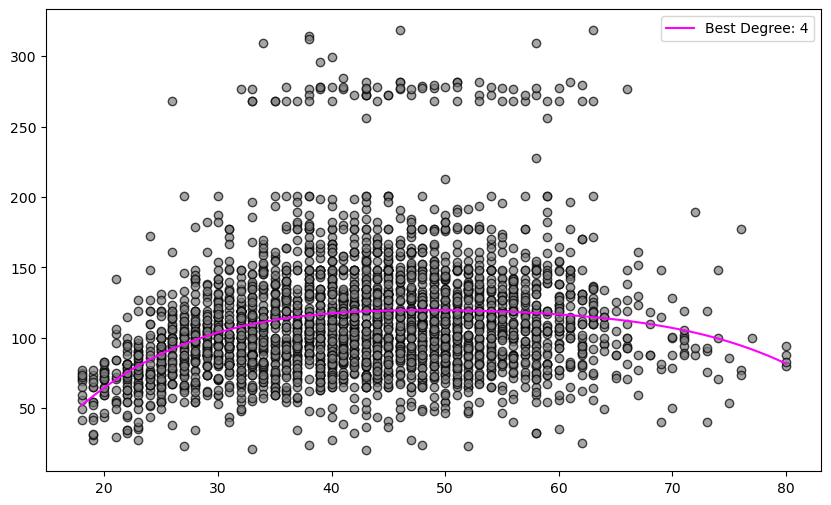

In [126]:
best_degree = grid_search.best_params_['poly__degree']
best_model = grid_search.best_estimator_.named_steps['model']
coefs = best_model.coef_
intercept = best_model.intercept_

xs = np.linspace(X.min().values[0], X.max().values[0], 1000)
ys = intercept[0] + coefs[0][1] * xs + coefs[0][2] * xs ** 2 + coefs[0][3] * xs ** 3 + coefs[0][4] * xs ** 4


plt.figure(figsize=(10, 6))
plt.plot(xs, ys, label=f'Best Degree: {best_degree}', color='magenta')
plt.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7)
plt.legend()
plt.show()

### (b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [127]:
pipe = Pipeline(steps=[
    ('discretizer', KBinsDiscretizer(n_bins=1, encode='ordinal', strategy='quantile')),
    ('encoder', OneHotEncoder(categories='auto', drop='first')),
    ('model', LinearRegression())
])
pipe.get_params()

{'memory': None,
 'steps': [('discretizer', KBinsDiscretizer(encode='ordinal', n_bins=1)),
  ('encoder', OneHotEncoder(drop='first')),
  ('model', LinearRegression())],
 'verbose': False,
 'discretizer': KBinsDiscretizer(encode='ordinal', n_bins=1),
 'encoder': OneHotEncoder(drop='first'),
 'model': LinearRegression(),
 'discretizer__dtype': None,
 'discretizer__encode': 'ordinal',
 'discretizer__n_bins': 1,
 'discretizer__random_state': None,
 'discretizer__strategy': 'quantile',
 'discretizer__subsample': 'warn',
 'encoder__categories': 'auto',
 'encoder__drop': 'first',
 'encoder__dtype': numpy.float64,
 'encoder__feature_name_combiner': 'concat',
 'encoder__handle_unknown': 'error',
 'encoder__max_categories': None,
 'encoder__min_frequency': None,
 'encoder__sparse_output': True,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__n_jobs': None,
 'model__positive': False}

In [131]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid={"discretizer__n_bins": np.linspace(1, 20, 20, dtype=int)},
    cv=5,
    scoring="neg_mean_squared_error",
)
grid_search.fit(X, y)

/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/pip

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('discretizer',
                                        KBinsDiscretizer(encode='ordinal',
                                                         n_bins=1)),
                                       ('encoder', OneHotEncoder(drop='first')),
                                       ('model', LinearRegression())]),
             param_grid={'discretizer__n_bins': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='neg_mean_squared_error')

/Users/filipsjostrand/anaconda3/envs/islp/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


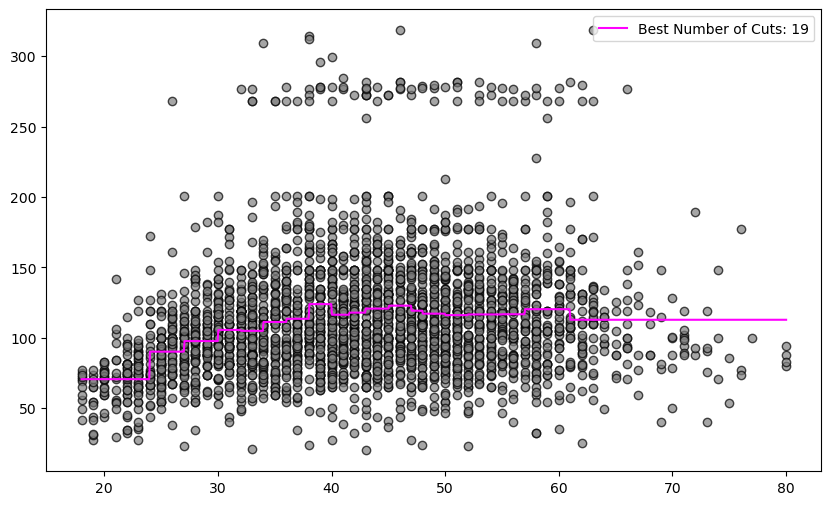

In [130]:
xs_reshaped = xs.reshape(-1, 1)
ys = grid_search.best_estimator_.predict(xs_reshaped)

plt.figure(figsize=(10, 6))
plt.plot(
    xs,
    ys,
    color="magenta",
    label=f'Best Number of Cuts: {grid_search.best_estimator_.named_steps["discretizer"].n_bins}',
)
plt.scatter(
    X["age"], y["wage"], edgecolor="k", facecolor="grey", alpha=0.7)
plt.legend()
plt.show()

# Question 8

### Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [150]:
auto = load_data("Auto")

In [151]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


There appears to be an interesting non-linearity between mpg and horsepower as well as between mpg and acceleration.

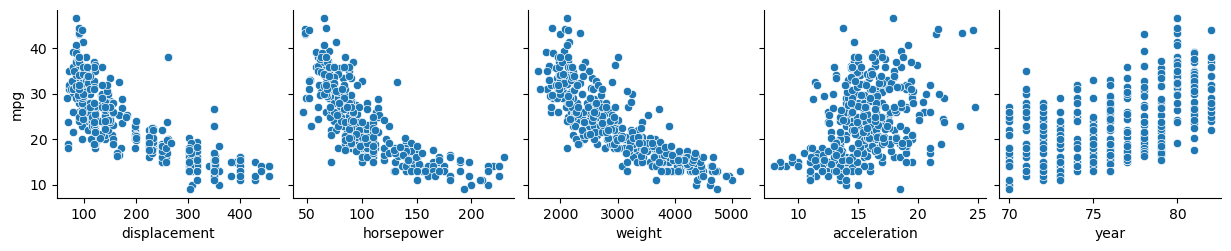

In [157]:
sns.pairplot(auto, y_vars=["mpg"], x_vars=auto.columns.drop(["mpg", "name", "cylinders", "origin"]))

In [ ]:
pipe = Pipeline([
    ()
])